## Importing Modules

In [1]:
import warnings
warnings.filterwarnings('ignore')
#Importing Necessary Modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
#import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier

## Data Preprocessing 

In [2]:
attrition_df = pd.read_csv('HR-Employee-Attrition.csv')
attrition_df = pd.get_dummies(attrition_df) #Convert categorical columns to discrete numbers
attrition_df = attrition_df.drop(['Attrition_No','Gender_Female','OverTime_No','EmployeeCount',
                                  'StandardHours','Over18_Y',
                                  'EmployeeNumber'],axis=1) #Dropping useless columns (Same value, ID, Extra Category)

attrition_df = attrition_df.rename(columns={"Attrition_Yes": "Attrition", "OverTime_Yes": "OverTime"}) 
#Because converted categorical columns change names, change binary categories back to their original names

y= attrition_df['Attrition']
X=attrition_df.drop('Attrition',axis=1) #Separate data into X and Y columns

non_numeric_cols = ['JobLevel','StockOptionLevel','BusinessTravel_Non-Travel','BusinessTravel_Travel_Frequently',
                    'BusinessTravel_Travel_Rarely','Department_Human Resources','Department_Research & Development',
                    'Department_Sales','EducationField_Human Resources','EducationField_Life Sciences',
                    'EducationField_Marketing','EducationField_Medical','EducationField_Other',
                    'EducationField_Technical Degree','Gender_Male','JobRole_Healthcare Representative',
                    'JobRole_Manufacturing Director','JobRole_Human Resources','JobRole_Laboratory Technician',
                    'JobRole_Manager','JobRole_Research Director','JobRole_Research Scientist','JobRole_Sales Executive',
                    'JobRole_Sales Representative','MaritalStatus_Divorced','MaritalStatus_Married','MaritalStatus_Single',
                    'OverTime','Education','EnvironmentSatisfaction','JobInvolvement','JobSatisfaction','PerformanceRating',
                    'RelationshipSatisfaction','WorkLifeBalance'] #Categorical Columns

numeric_df = attrition_df.drop(non_numeric_cols, axis=1) #Dataframe with only numerical columns, including Y-column 'Attrition'

print(numeric_df.columns)



Index(['Age', 'DailyRate', 'DistanceFromHome', 'HourlyRate', 'MonthlyIncome',
       'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany',
       'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'Attrition'],
      dtype='object')


## Experimenting with Correlation

to_drop columns:  ['JobLevel', 'MonthlyIncome', 'PercentSalaryHike', 'YearsAtCompany', 'YearsInCurrentRole', 'BusinessTravel_Travel_Frequently', 'Department_Human Resources', 'Department_Research & Development', 'Department_Sales']


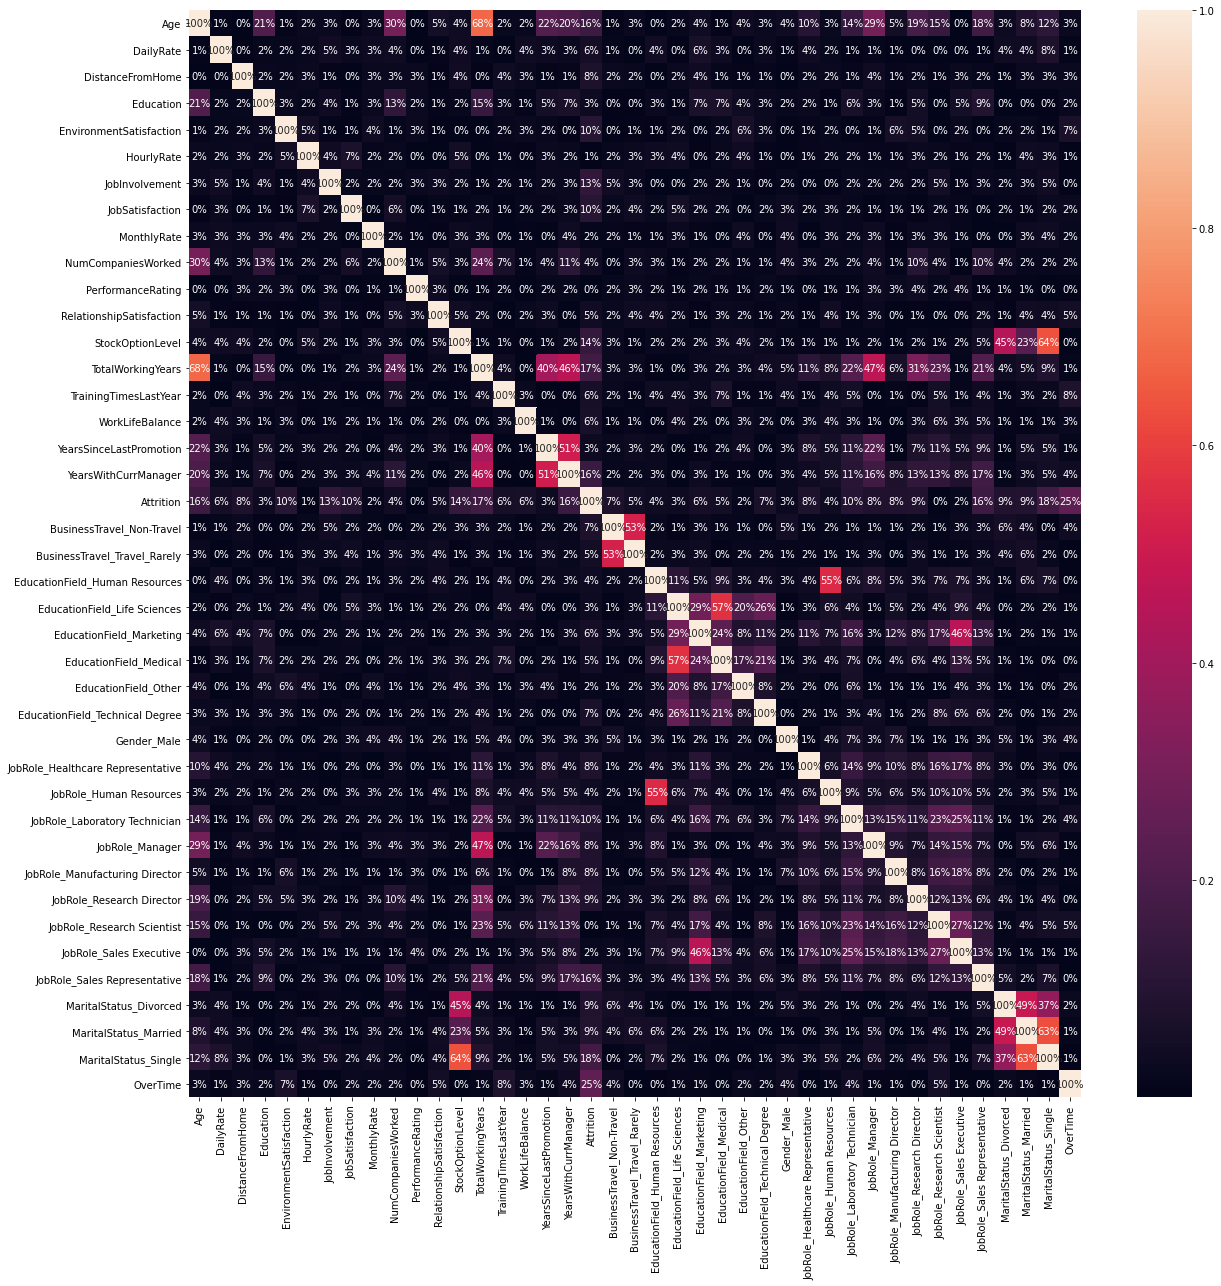

In [3]:
corr_mask = np.triu(np.ones_like(attrition_df.corr(), dtype=bool))
tri_df = attrition_df.corr().abs().mask(corr_mask)
plt.figure(figsize=(20,20))
#sns.heatmap(attrition_df.corr().abs(),mask=corr_mask,annot=True,fmt='.0%')
to_drop = [c for c in tri_df.columns if any(tri_df[c] > 0.7)]
print('to_drop columns: ', to_drop)
df_exp = attrition_df.drop(to_drop, axis=1)
df_exp.corr()
sns.heatmap(df_exp.corr().abs(),annot=True,fmt='.0%')

X_corr= df_exp.drop('Attrition',axis=1)
y_corr=df_exp['Attrition']

## Data Visualization 

Text(0.5, 1.0, 'Attrition Rate Among Different Gender And Age Group')

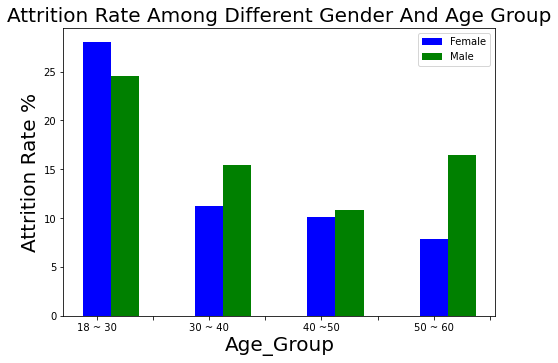

In [65]:
# make a copy of data
visual_x = attrition_df
# range of age
min(visual_x['Age'])
max(visual_x['Age'])
visual_x['Age_Group'] = 'a'
for i in range(len(visual_x['Age'])):
    if 18 <= visual_x['Age'][i] <= 30:
        visual_x['Age_Group'][i] = '18 ~ 30'
    elif 30 < visual_x['Age'][i] <= 40:
        visual_x['Age_Group'][i] = '30 ~ 40'
    elif 40 < visual_x['Age'][i] <= 50:
        visual_x['Age_Group'][i] = '40 ~ 50'
    else:
        visual_x['Age_Group'][i] = '50 ~ 60'


# Attrition Rate Among Different Gender And Age Group
groupped_data1 = visual_x[visual_x['Attrition'] == 1].groupby(["Gender_Male", "Age_Group"]).count()['Age']
groupped_data2 = visual_x.groupby(["Gender_Male", "Age_Group"]).count()['Age']
groupped_data = (groupped_data1/groupped_data2) * 100
labels = ['', '18 ~ 30', '', '30 ~ 40', '', '40 ~50', '', '50 ~ 60']
fig = plt.figure()
x_bar = np.arange(4)
ax = fig.add_axes([0,0,1,1])
ax.bar(x_bar + 0.00, groupped_data[0], color = 'b', width = 0.25)
ax.bar(x_bar + 0.25, groupped_data[1], color = 'g', width = 0.25)
ax.legend(labels=['Female', 'Male'])
ax.set_xticklabels(labels)
plt.xlabel('Age_Group', size = 20)
plt.ylabel('Attrition Rate %', size = 20)
plt.title('Attrition Rate Among Different Gender And Age Group', size = 20)


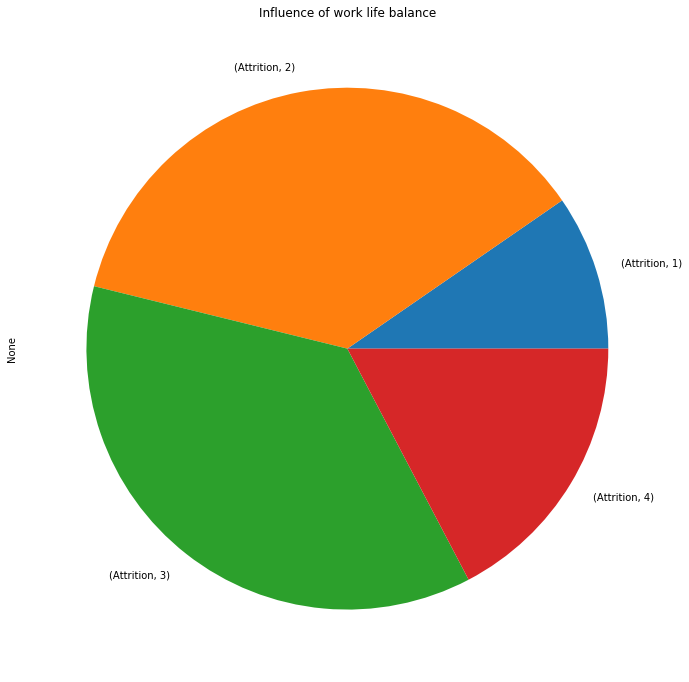

In [62]:
data = df_exp[df_exp['JobSatisfaction']==4]
d = {'WorkLifeBalance' : data['WorkLifeBalance'], 
      'Attrition' : data['Attrition']}
worklife_balance = pd.DataFrame(d) 
worklife_balance_groupby = worklife_balance.groupby(['WorkLifeBalance'])
worklife_balance_groupby.sum().unstack().plot(kind='pie',title="Influence of work life balance",figsize=(12,12))


## Linear Model Construction and Model Evaluation 

In [4]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

regr = OLS(y, add_constant(X)).fit()
print(regr.aic)

#fit simple linear regression model
model = sm.OLS(y, X).fit()

#view model summary
print(model.summary())

882.5728854870249
                            OLS Regression Results                            
Dep. Variable:              Attrition   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     11.24
Date:                Sat, 12 Dec 2020   Prob (F-statistic):           6.55e-65
Time:                        00:22:46   Log-Likelihood:                -396.29
No. Observations:                1470   AIC:                             882.6
Df Residuals:                    1425   BIC:                             1121.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

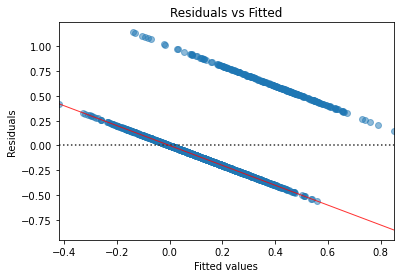

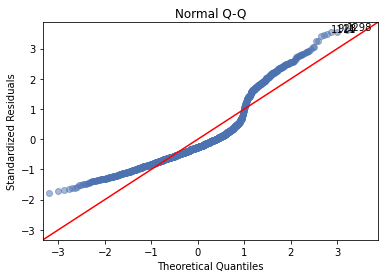

In [5]:
# model values
y_pred = model.fittedvalues
# model residuals
residuals = model.resid
# normalized residuals
model_norm_residuals = model.get_influence().resid_studentized_internal
# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
# absolute residuals
model_abs_resid = np.abs(residuals)
# leverage, from statsmodels internals
model_leverage = model.get_influence().hat_matrix_diag
# cook's distance, from statsmodels internals
model_cooks = model.get_influence().cooks_distance[0]

dataframe = pd.concat([X, y], axis=1)

plot_lm_1 = plt.figure()
plot_lm_1.axes[0] = sns.residplot(y_pred, dataframe.columns[-1], data=dataframe,
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');

# Noraml Q-Q plot
QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');
# annotations
abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:3]
for r, i in enumerate(abs_norm_resid_top_3):
    plot_lm_2.axes[0].annotate(i,
                               xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                   model_norm_residuals[i]));

## Logistic Model Construction and Model Evaluation

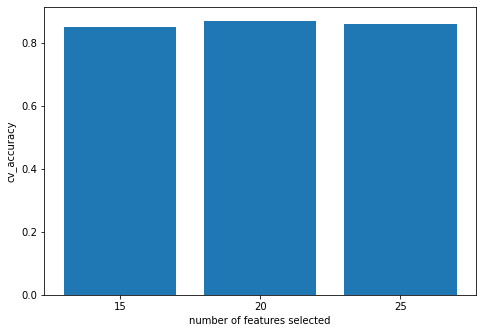

In [74]:
# Feature Selection n_feature parameter tuning result
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
n_features = ['15', '20', '25']
cv_accuracy = [0.85,0.87, 0.86]
ax.bar(langs,students)
plt.xlabel('number of features selected')
plt.ylabel('cv_accuracy')
plt.show()

In [67]:
# Using RFE to selecting features
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
rfe = RFE(logreg,25)
rfe = rfe.fit(X, y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[False False False False  True False  True  True  True False False False
 False False  True  True False  True  True False False False False  True
  True False False False  True  True False  True False False  True  True
  True  True  True  True  True  True False False  True  True False  True
  True]
[21 24 14 19  1 22  1  1  1 23 25  4 15 12  1  1 10  1  1  9  2  3  6  1
  1  5  7 18  1  1 13  1  8 11  1  1  1  1  1  1  1  1 17 20  1  1 16  1
  1]


In [68]:
# The selected columns are:
selected = []
for i in range(len(rfe.support_)):
    if rfe.support_[i] == True:
        selected.append(X.columns[i])
selected

['EnvironmentSatisfaction',
 'JobInvolvement',
 'JobLevel',
 'JobSatisfaction',
 'RelationshipSatisfaction',
 'StockOptionLevel',
 'TrainingTimesLastYear',
 'WorkLifeBalance',
 'BusinessTravel_Non-Travel',
 'BusinessTravel_Travel_Frequently',
 'Department_Sales',
 'EducationField_Human Resources',
 'EducationField_Marketing',
 'EducationField_Technical Degree',
 'Gender_Male',
 'JobRole_Healthcare Representative',
 'JobRole_Human Resources',
 'JobRole_Laboratory Technician',
 'JobRole_Manager',
 'JobRole_Manufacturing Director',
 'JobRole_Research Director',
 'JobRole_Sales Representative',
 'MaritalStatus_Divorced',
 'MaritalStatus_Single',
 'OverTime']

In [69]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X[selected])
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: inf
         Iterations 8
                                 Results: Logit
Model:                      Logit                  Pseudo R-squared:       inf   
Dependent Variable:         Attrition              AIC:                    inf   
Date:                       2020-12-12 01:46       BIC:                    inf   
No. Observations:           1470                   Log-Likelihood:         -inf  
Df Model:                   24                     LL-Null:                0.0000
Df Residuals:               1445                   LLR p-value:            1.0000
Converged:                  1.0000                 Scale:                  1.0000
No. Iterations:             8.0000                                               
---------------------------------------------------------------------------------
                                   Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------

/Users/ranpei/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
/Users/ranpei/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '


In [55]:
# for those whose p-value is larger than 0.05, drop those columns 20
for i in ['WorkLifeBalance', 'EducationField_Human Resources', 'JobRole_Human Resources', 'MaritalStatus_Divorced', 'JobRole_Research Director', 'JobRole_Manufacturing Director', 'JobRole_Healthcare Representative', 'EducationField_Marketing', 'JobRole_Manager', '']:
    selected.remove(i)

In [70]:
#25
#for i in ['JobLevel', 'RelationshipSatisfaction', 'StockOptionLevel', 'TrainingTimesLastYear', 'WorkLifeBalance', 'Department_Sales', 'EducationField_Human Resources', 'EducationField_Marketing', 'JobRole_Healthcare Representative', 'JobRole_Human Resources', 'JobRole_Manufacturing Director', 'MaritalStatus_Divorced']:
    #selected.remove(i)

In [64]:
#15
#for i in ['EducationField_Human Resources', 'EducationField_Marketing', 'JobRole_Human Resources', 'JobRole_Research Director']:
    #selected.remove(i)

In [71]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X[selected])
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: inf
         Iterations 8
                                 Results: Logit
Model:                     Logit                  Pseudo R-squared:       inf   
Dependent Variable:        Attrition              AIC:                    inf   
Date:                      2020-12-12 01:50       BIC:                    inf   
No. Observations:          1470                   Log-Likelihood:         -inf  
Df Model:                  12                     LL-Null:                0.0000
Df Residuals:              1457                   LLR p-value:            1.0000
Converged:                 1.0000                 Scale:                  1.0000
No. Iterations:            8.0000                                               
--------------------------------------------------------------------------------
                                  Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------

/Users/ranpei/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
/Users/ranpei/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '


In [72]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X[selected], y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

score = cross_val_score(logreg, X_test, y_test, cv=5, scoring='accuracy')
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(score.mean()))

Accuracy of logistic regression classifier on test set: 0.86


<function confusion_matrix at 0x7fb79296d790>


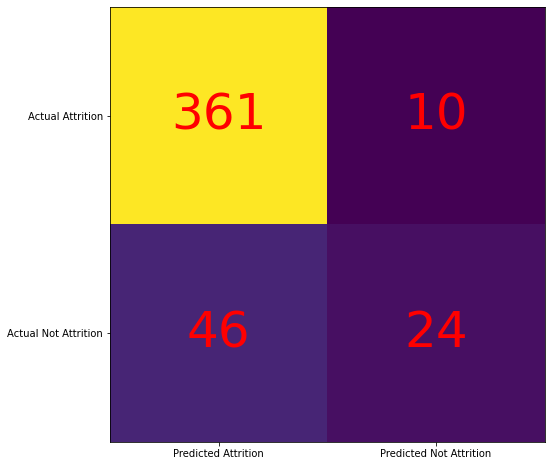

In [25]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(confusion_matrix)


fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted Attrition', 'Predicted Not Attrition'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual Attrition', 'Actual Not Attrition'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red', size = 50)
plt.show()



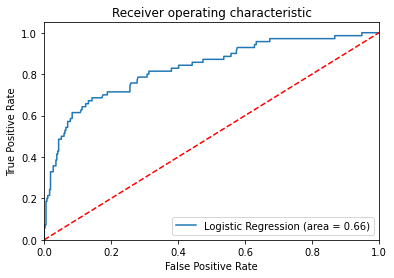

In [13]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## Lasso Regression Construction and Model Evaluation

In [39]:
# evaluate an lasso regression model on the dataset
from numpy import mean
from numpy import std
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso

# define model
lasso_model = Lasso(alpha=1)
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
scores = cross_val_score(lasso_model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
#score = cross_val_score(RDF, X_train, y_train, cv=k_fold, scoring='accuracy')
# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean MAE: 0.265 (0.021)


In [40]:
# define model
lasso_model = Lasso()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid['alpha'] = np.arange(0, 1, 0.01)
# define search
search = GridSearchCV(lasso_model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X_train, y_train)
# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

MAE: -0.248
Config: {'alpha': 0.0}


In [43]:
# Therefore we use alpha = 0.01 as the penalty
lasso_model = Lasso(alpha=0.01)


lasso_model.fit(X_test, y_test)

y_pred = lasso_model.predict(X_test)

#cm = confusion_matrix(y_test, y_pred)
#print(confusion_matrix)

## Glmnet Construction and Model Evaluation 

In [67]:
import glmnet_python
from glmnet import glmnet
#fit = glmnet(x = X.copy(), y = y.copy(), family = 'binomial')

## Naive Bayes Construction and Model Evaluation 

## Random Forest Construction and Model Evaluation 

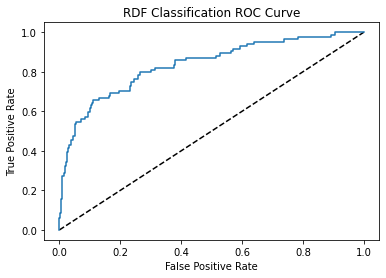

auc_score:  0.8347338935574229


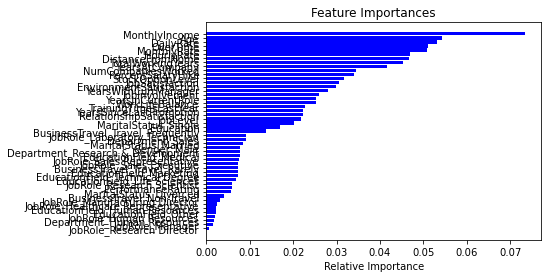

[[354   3]
 [ 71  13]]
accuracy:  0.8321995464852607
recall:  0.8329411764705882
FPR:  0.1875
cv_accuracy_score:  0.8600513992004568


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)
RDF = RandomForestClassifier(random_state=123, max_depth=10, n_estimators=500)
RDF.fit(X_train, y_train)
y_pred = RDF.predict(X_test)
y_prob = RDF.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='Random Forest Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RDF Classification ROC Curve')
plt.show()
print('auc_score: ', roc_auc_score(y_test, y_prob))

features = X.columns
importances = RDF.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)
print('accuracy: ', (cf_matrix[0,0]+cf_matrix[1,1])/np.sum(cf_matrix))
print('recall: ', cf_matrix[0,0]/(cf_matrix[0,0]+cf_matrix[1,0]))
print('FPR: ', cf_matrix[0,1]/(cf_matrix[0,1]+cf_matrix[1,1]))

k_fold = KFold(n_splits=10, shuffle=True, random_state=123)
score = cross_val_score(RDF, X_train, y_train, cv=k_fold, scoring='accuracy')
print('cv_accuracy_score: ',score.mean())

## Hyperparameter Tuning using GridSearchCV

In [19]:
#Hyper-parameter Tuning

#random_grid = {'n_estimators': [100, 200, 300, 500],
               #'max_depth': [5, 10, 20, 30]}

#grid_search = GridSearchCV(estimator = RDF, param_grid = random_grid, 
                          #cv = k_fold, verbose = 1)

#grid_search.fit(X_train, y_train)
#print(print(grid_search.best_params_))

## Using reduced columns based on feature importance to construct a new RDFR Model

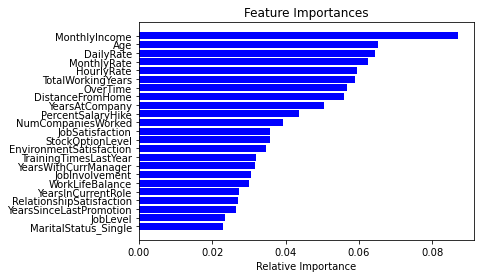

[[353   4]
 [ 73  11]]
accuracy:  0.8253968253968254
recall:  0.8286384976525821
FPR:  0.26666666666666666
cv_accuracy_score:  0.8619836284028175


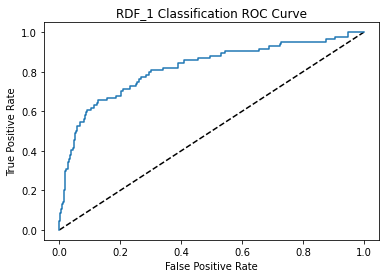

auc score: 0.8189942643724157


In [21]:
fi_mask = RDF.feature_importances_ > 0.02
X_reduced = X.loc[:, fi_mask]

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=10)
RDF1 = RandomForestClassifier(random_state=123,max_depth=10, n_estimators=500)
RDF1.fit(X_train, y_train)
y_pred = RDF1.predict(X_test)
y_prob = RDF1.predict_proba(X_test)[:,-1]


features = X_reduced.columns
importances = RDF1.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)
print('accuracy: ', (cf_matrix[0,0]+cf_matrix[1,1])/np.sum(cf_matrix))
print('recall: ', cf_matrix[0,0]/(cf_matrix[0,0]+cf_matrix[1,0]))
print('FPR: ', cf_matrix[0,1]/(cf_matrix[0,1]+cf_matrix[1,1]))

k_fold = KFold(n_splits=10, shuffle=True, random_state=123)
score = cross_val_score(RDF1, X_train, y_train, cv=k_fold, scoring='accuracy')
print('cv_accuracy_score: ',score.mean())

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='Random Forest Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RDF_1 Classification ROC Curve')
plt.show()

print('auc score:',roc_auc_score(y_test, y_prob))



## XGBoost

In [21]:
X=attrition_df.drop('Attrition',axis=1)
y=attrition_df['Attrition']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

#{'colsample_bytree': 0.5, 'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 300}
xg_cl=xgb.XGBClassifier(eval_metric='logloss',seed=10,use_label_encoder=False, objective='binary:logistic',
                       colsample_bytree=0.5, learning_rate=0.2, max_depth=8, n_estimators=300)

xg_cl.fit(X_train, y_train)
y_pred=xg_cl.predict(X_test)
y_prob = xg_cl.predict_proba(X_test)[:,1]

cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)
print('accuracy: ', (cf_matrix[0,0]+cf_matrix[1,1])/np.sum(cf_matrix))
print('recall: ', cf_matrix[0,0]/(cf_matrix[0,0]+cf_matrix[1,0]))
print('FPR: ', cf_matrix[0,1]/(cf_matrix[0,1]+cf_matrix[1,1]))

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='XGBClassifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGB Classification ROC Curve')
plt.show()
print('auc_score: ', roc_auc_score(y_test, y_prob))

score = cross_val_score(xg_cl, X_train, y_train, cv=5, scoring='accuracy')
print('cv_accuracy_score: ',score.mean())

features = X.columns
importances = xg_cl.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

NameError: name 'xgb' is not defined

In [ ]:
#params = {'max_depth':[3,5,8,10],
         #'learning_rate':[0.2, 0.1],
         #'colsample_bytree':[0.5, 0.6, 0.8, 1],
         #'n_estimators':[100, 200, 300]}

#grid_search = GridSearchCV(estimator=xg_cl, param_grid=params, cv=5, verbose=1, scoring='accuracy')

#grid_search.fit(X_train, y_train)

#print(grid_search.best_params_)

## XGBOOST Using Reduced Columns

[[232   7]
 [ 33  22]]
accuracy:  0.8639455782312925
recall:  0.8754716981132076
FPR:  0.2413793103448276


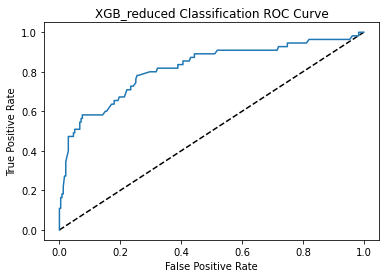

auc_score:  0.8179155572461012
cv_accuracy_score:  0.8596898665705013


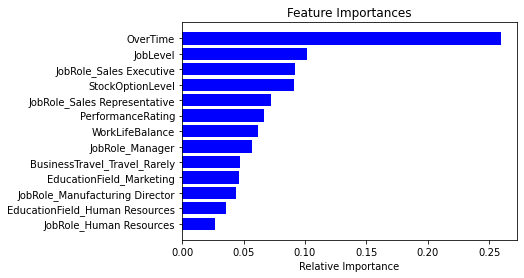

In [100]:
fi_mask = xg_cl.feature_importances_ > 0.02
X_reduced = X.loc[:, fi_mask]

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=10)
#{'colsample_bytree': 0.5, 'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 100}
xg_cl1 = xgb.XGBClassifier(eval_metric='logloss', seed=10,use_label_encoder=False, objective='binary:logistic',
                          colsample_bytree=0.5, learning_rate=0.2, max_depth=8, n_estimators=100)

xg_cl1.fit(X_train, y_train)
y_pred=xg_cl1.predict(X_test)
y_prob = xg_cl1.predict_proba(X_test)[:,1]

cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)
print('accuracy: ', (cf_matrix[0,0]+cf_matrix[1,1])/np.sum(cf_matrix))
print('recall: ', cf_matrix[0,0]/(cf_matrix[0,0]+cf_matrix[1,0]))
print('FPR: ', cf_matrix[0,1]/(cf_matrix[0,1]+cf_matrix[1,1]))

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='XGBClassifier_reduced')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGB_reduced Classification ROC Curve')
plt.show()
print('auc_score: ', roc_auc_score(y_test, y_prob))

score = cross_val_score(xg_cl1, X_train, y_train, cv=5, scoring='accuracy')
print('cv_accuracy_score: ',score.mean())

features = X_reduced.columns
importances = xg_cl1.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


In [101]:
#params = {'max_depth':[3,5,8,10],
         #'learning_rate':[0.2, 0.1],
         #'colsample_bytree':[0.5, 0.6, 0.8, 1],
         #'n_estimators':[100, 200, 300]}

#grid_search = GridSearchCV(estimator=xg_cl1, param_grid=params, cv=5, verbose=1, scoring='accuracy')

#grid_search.fit(X_train, y_train)
#print(grid_search.best_params_)




# K nearest neighbors

In [22]:
knn = KNeighborsClassifier(n_neighbors=5)
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
grid.fit(X, y)
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.84421768707483
{'n_neighbors': 10}
KNeighborsClassifier(n_neighbors=10)


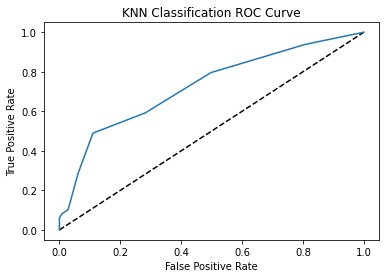

area:  0.7256143273635985
accuracy 0.8435374149659864


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=14)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
y_prob = knn.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='KNN Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN Classification ROC Curve')
plt.show()
print('area: ', roc_auc_score(y_test, y_prob))
print('accuracy', knn.score(X_test,y_test))

# Kernel Support Vector Machine with parameters tuning

In [24]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
# from sklearn.svm import SVC
# params = {'C':[0.1,1,10,100,1000],
#          'gamma':[0.0001,0.001,0.01,0.1,1],
#          'kernel':['rbf','sigmoid']}

# grid_search = GridSearchCV(SVC(), params)

# grid_search.fit(X_train, y_train)

# print(grid_search.best_params_)
# print(grid_search.best_score_)

Gaussian Kernel

[[238   1]
 [ 54   1]]


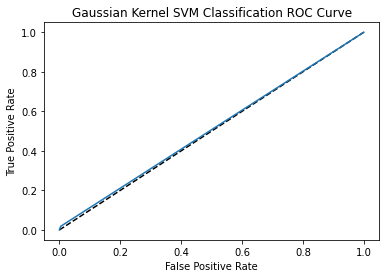

area:  0.506998858881704
accuracy 0.8129251700680272
cv_accuracy_score:  0.8452398124774613


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=10)
from sklearn.svm import SVC
svclassifier = SVC(C=10,gamma=0.0001,kernel='rbf')
svclassifier.fit(X_train, y_train)
y_pred = svclassifier.predict(X_test)

print(confusion_matrix(y_test,y_pred))
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='Gaussian Kernel SVM Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gaussian Kernel SVM Classification ROC Curve')
plt.show()
print('area: ',  auc(fpr,tpr))
print('accuracy', svclassifier.score(X_test,y_test))
score = cross_val_score(svclassifier, X_train, y_train, cv=5, scoring='accuracy')
print('cv_accuracy_score: ',score.mean())

# Naive Bayes

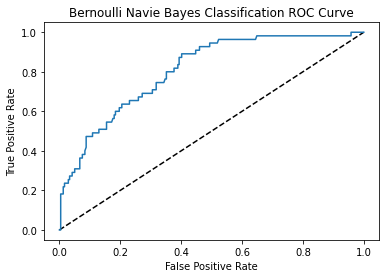

[[222  17]
 [ 35  20]]
auc_score:  0.806047926968429
accuracy 0.8231292517006803


In [26]:
import numpy as np
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:,1]

# redundant code
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='Bernoulli Naive Bayes Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Bernoulli Navie Bayes Classification ROC Curve')
plt.show()
print(confusion_matrix(y_test,y_pred))
print('auc_score: ', roc_auc_score(y_test, y_prob))
print('accuracy', clf.score(X_test,y_test))

# LightGBM

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 10)
import lightgbm as lgb
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
from sklearn.metrics import accuracy_score
y_prob = clf.predict_proba(X_test)[:,1]
print(confusion_matrix(y_test,y_pred))
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='Sigmoid Kernel SVM Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Sigmoid Kernel SVM Classification ROC Curve')
plt.show()
print('area: ', roc_auc_score(y_test, y_prob))
print('accuracy', accuracy_score(y_pred, y_test))
score = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
print('cv_accuracy_score: ',score.mean())

OSError: dlopen(/Users/ranpei/opt/anaconda3/lib/python3.8/site-packages/lightgbm/lib_lightgbm.so, 6): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib
  Referenced from: /Users/ranpei/opt/anaconda3/lib/python3.8/site-packages/lightgbm/lib_lightgbm.so
  Reason: image not found

In [30]:
# params = {'num_leaves':[8,32,128,1024],
#          'max_depth':[3,5,7,10],
#          'min_data_in_leaf':[10,50,100,200,400],
#          'learning_rate':[0.1,0.2],
#          'max_bin':[50,70,90,100],}
# #          'n_estimators':[100, 200, 300,400,500]}

# grid_search = GridSearchCV(estimator=clf, param_grid=params, cv=5)

# grid_search.fit(X_train, y_train)

# print(grid_search.best_params_)
# print(grid_search.best_score_)

# LightGBM feature selection and paramters tuning

In [31]:
fi_mask = clf.feature_importances_ > 0.02
X_reduced = X.loc[:, fi_mask]

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=10)
clf = lgb.LGBMClassifier(learning_rate=0.1, max_bin=70, max_depth=5, min_data_in_leaf=50, num_leaves=32)
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
from sklearn.metrics import accuracy_score
y_prob = clf.predict_proba(X_test)[:,1]
print(confusion_matrix(y_test,y_pred))
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='Sigmoid Kernel SVM Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Sigmoid Kernel SVM Classification ROC Curve')
plt.show()
print('area: ', roc_auc_score(y_test, y_prob))
print('accuracy', accuracy_score(y_pred, y_test))
score = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
print('cv_accuracy_score: ',score.mean())

AttributeError: 'BernoulliNB' object has no attribute 'feature_importances_'